In [18]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
from cryoem.quaternions import euler2quaternion, d_q
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude, plot_distances_count
from cryoem.angle_alignment import distance_difference
import ipyvolume as ipv
from IPython import display
import time

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
ap = np.load("data/predicted_angles_var0.8.npy")

In [5]:
distance_difference(angles_predicted=ap, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 0.430 rad (24.656 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.430 rad (24.656 degrees)


In [6]:
# np.savez(f"{PROTEIN}_projections_and_angles", projections, ap)

---

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_q(q_i, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \hat{q_i})
\end{equation}

- $d_q$ is the distance between two quaternions

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [7]:
from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

def quaternion2euler(quaternions):
    """https://github.com/tensorflow/graphics/blob/master/tensorflow_graphics/geometry/transformation/euler.py"""
    def general_case(r02, r12, r20, r21, r22, eps_addition):
        """Handles the general case."""
        theta_y = tf.acos(r22)
        sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
        r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
        r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        theta_z0 = tf.atan2(r12 * sign_sin_theta_y, r02 * sign_sin_theta_y)
        theta_z1 = tf.atan2(r21 * sign_sin_theta_y, -r20 * sign_sin_theta_y)
        return tf.stack((theta_z0, theta_y, theta_z1), axis=-1)

    def gimbal_lock(r22, r11, r10, eps_addition):
        """Handles Gimbal locks."""
        sign_r22 = safe_ops.nonzero_sign(r22)
        r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        theta_z0 = tf.atan2(-sign_r22 * r10, -sign_r22 * r11)  # TODO: was -
        theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
        theta_z1 = tf.zeros_like(theta_z0)
        angles = tf.stack((theta_z0, theta_y, theta_z1), axis=-1)
        return angles

    with tf.compat.v1.name_scope(None, "euler_from_quaternion", [quaternions]):
        quaternions = tf.convert_to_tensor(value=quaternions)

        shape.check_static(
            tensor=quaternions,
            tensor_name="quaternions",
            has_dim_equals=(-1, 4))

        x, y, z, w = tf.unstack(quaternions, axis=-1)
        tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
        ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
        tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
        twx = tx * w
        twy = ty * w
        twz = tz * w
        txx = tx * x
        txy = ty * x
        txz = tz * x
        tyy = ty * y
        tyz = tz * y
        tzz = tz * z

        # The following is clipped due to numerical instabilities that can take some
        # enties outside the [-1;1] range.
        r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
        r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
        r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)
        
        r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
        r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
        r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)
        
        r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
        r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
        r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)

#         r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
#         r01 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
#         r02 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
        
#         r10 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
#         r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
#         r12 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
        
#         r20 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)
#         r21 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)
#         r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
        eps_addition = asserts.select_eps_for_addition(quaternions.dtype)
        general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
        gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
        # The general solution is unstable close to the Gimbal lock, and the gimbal
        # solution is not toooff in these cases.
        is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
        gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
        return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)  

In [8]:
def euler6tomarix4d(a_R):
    a, b, g, l, t, p = tf.unstack(a_R, axis=-1)
    
    ca = tf.cos(a)
    cb = tf.cos(b)
    cg = tf.cos(g)
    cl = tf.cos(l)
    ct = tf.cos(t)
    cp = tf.cos(p)
    
    sa = tf.sin(a)
    sb = tf.sin(b)
    sg = tf.sin(g)
    sl = tf.sin(l)
    st = tf.sin(t)
    sp = tf.sin(p)

   

    Ra = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   ca, 0.0), tf.complex(  -sa, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   sa, 0.0), tf.complex(   ca, 0.0)], axis=0)]], axis=0)

    Rb = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(   cb, 0.0), tf.complex([0.0], 0.0), tf.complex(   sb, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(  -sb, 0.0), tf.complex([0.0], 0.0), tf.complex(   cb, 0.0)], axis=0)]], axis=0)
    
    Rg = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( cg, 0.0), tf.complex(-sg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( sg, 0.0), tf.complex( cg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rl = tf.concat([ [tf.concat([ tf.complex( cl, 0.0), tf.complex([0.0], -sl), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sl), tf.complex( cl, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rt = tf.concat([ [tf.concat([ tf.complex( ct, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -st), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -st), tf.complex([0.0], 0.0), tf.complex( ct, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rp = tf.concat([ [tf.concat([ tf.complex( cp, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -sp)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sp), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(cp, 0.0)], axis=0)]], axis=0)
    
    R = Ra @ Rb @ Rg @ Rl @ Rt @ Rp
    
    # check if matrix is complex (shouldn't be)
    assert tf.reduce_sum(tf.math.imag(R)) == 0.0, "Matrix R (4x4) should have 0s as imaginary parts"
    R = tf.cast(R, dtype=tf.float64)
    
    # check if matrix is orthogonal
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.math.subtract(tf.transpose(R), tf.linalg.inv(R))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
      
    return R


def update_angles(m, a_R, a_predicted):
    q_predicted = euler2quaternion(a_predicted)
    
    R = euler6tomarix4d(a_R)
    I = tf.eye(4, dtype=tf.float64)*tf.constant([m, 1.0, 1.0, 1.0], dtype=tf.float64)

    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))
    
    return quaternion2euler(q_predicted_rotated)


def loss_alignment(m, a_R, a_predicted, a_true):
    q_true = euler2quaternion(a_true)
    q_predicted = euler2quaternion(a_predicted)
    
    R = euler6tomarix4d(a_R)
    I = tf.eye(4, dtype=tf.float64)*tf.constant([m, 1.0, 1.0, 1.0], dtype=tf.float64)

    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))
    
    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, optimization=True):
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time()

    # collect rotations
    r = []
    # collect losses depending on rotation
    l = []
    ms = [ 1.0] # -1.0,

    for m in ms:
        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(angles_predicted)
    
        euler = np.zeros(6, dtype=np.float32)
        a_R = [tf.Variable(euler)]
        
        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(projection_idx, size=batch_size))

            # Compute distances between projections
            a_true      = [angles_true[i]      for i in idx]
            a_predicted = [angles_predicted[i] for i in idx]

            # Optimize by gradient descent.
            if optimization:
                losses[step-1], gradients = gradient_alignment(m, a_R, a_predicted, a_true)
                optimizer.apply_gradients(zip(gradients, a_R))
            else:
                losses[step-1] = loss_alignment(m, a_R, a_predicted, a_true)

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time() - time_start
                print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.median(losses[step-steps//10:step-1]):.2e}')
        print("-"*20)
        if optimization:
            # Plot convergence.
            fig, ax = plt.subplots()
            ax.plot(np.linspace(0, time()-time_start, steps), losses)
            ax.set_xlabel('time [s]')
            ax.set_ylabel('loss');
        else:
            print(f"Mean distance difference: {np.mean(losses)}")
         
        r.append(a_R)
        l.append(np.median(losses[-1-steps//10:-1]))
        
    for i, m in enumerate(ms):
        print(f"For m={m}, loss is: {l[i]}")
    
    idx_best = np.argmin(np.array(l))
    return ms[idx_best], r[idx_best], l[idx_best]

step 1000/10000 (100s): loss = 2.47e-01
step 2000/10000 (203s): loss = 2.47e-01
step 3000/10000 (310s): loss = 2.47e-01
step 4000/10000 (418s): loss = 2.48e-01
step 5000/10000 (522s): loss = 2.47e-01
step 6000/10000 (629s): loss = 2.48e-01
step 7000/10000 (739s): loss = 2.47e-01
step 8000/10000 (850s): loss = 2.47e-01
step 9000/10000 (960s): loss = 2.48e-01
step 10000/10000 (1065s): loss = 2.47e-01
--------------------


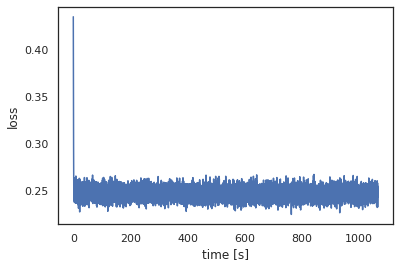

In [9]:
m, rotation, loss = training_angle_alignment(steps=100, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap, 
                         optimization=True)

In [10]:
m, rotation, loss

(1.0, [<tf.Variable 'Variable:0' shape=(6,) dtype=float32, numpy=
  array([-0.18933961,  0.00739453, -0.00040265,  0.        ,  0.        ,
          0.        ], dtype=float32)>], 0.24734832109938637)

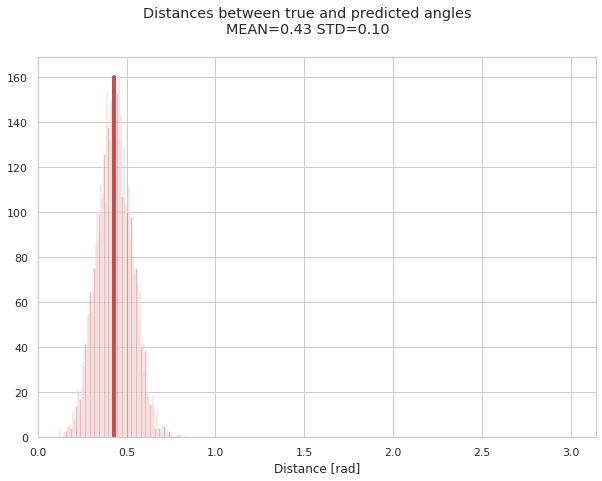

In [11]:
plot_distances_count(ap, angles_true)

In [12]:
distance_difference(angles_predicted=ap, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 0.430 rad (24.656 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.430 rad (24.656 degrees)


In [13]:
mat = update_angles(m, rotation, ap)
mat

<tf.Tensor: id=20621275, shape=(5000, 3), dtype=float64, numpy=
array([[ 3.10713486,  0.94551555, -0.99459874],
       [-0.78813004,  0.29916619,  1.14341873],
       [ 1.67639233,  0.02526483, -1.64551253],
       ...,
       [-0.76907343,  1.07286574, -0.82221561],
       [ 1.46626496,  0.84139281,  1.83367365],
       [ 2.80653097,  0.94840764,  2.09277746]])>

In [17]:
angles_true

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

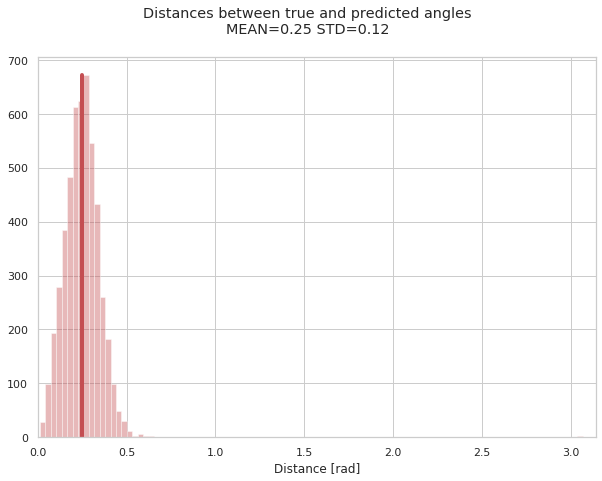

In [15]:
plot_distances_count(mat, angles_true)

In [16]:
distance_difference(angles_predicted=mat, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 0.249 rad (14.259 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.249 rad (14.259 degrees)


In [28]:
# np.savez(f"{PROTEIN}_projections_and_angles_quaterniontest_T", projections, mat)

In [ ]:
----

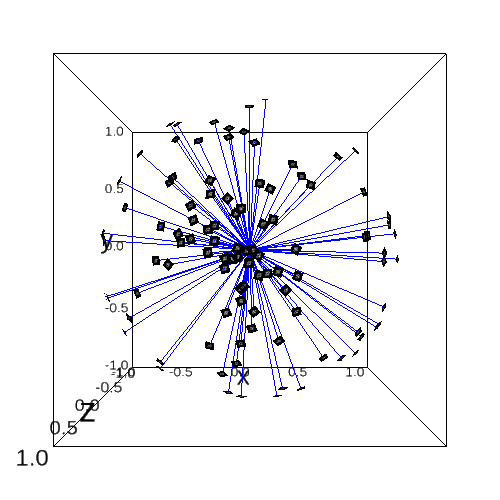

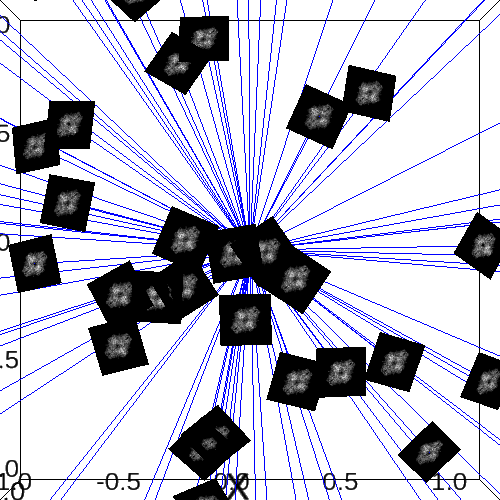

In [16]:
plot_images(mat, projections, indices=range(100),img_size_scale=0.05)

In [18]:
display(ipv.screenshot())

Output()

step 100/1000 (9s): loss = 1.81e+00
step 200/1000 (18s): loss = 1.81e+00
step 300/1000 (27s): loss = 1.81e+00
step 400/1000 (37s): loss = 1.82e+00
step 500/1000 (46s): loss = 1.81e+00
step 600/1000 (55s): loss = 1.82e+00
step 700/1000 (65s): loss = 1.80e+00
step 800/1000 (75s): loss = 1.81e+00
step 900/1000 (84s): loss = 1.82e+00
step 1000/1000 (94s): loss = 1.81e+00
--------------------


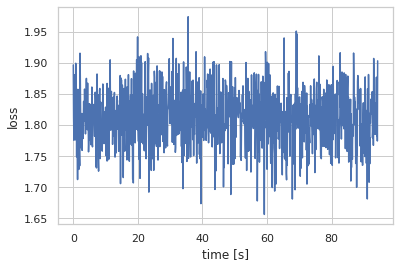

In [19]:
# ALIGN NEW ONES NOW
m, rotation, loss = training_angle_alignment(steps=1000, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=mat, 
                         optimization=True)

In [20]:
m, rotation, loss

(1.0, [<tf.Variable 'Variable:0' shape=(6,) dtype=float32, numpy=
  array([-1.0048243 , -0.00493759,  0.0077053 ,  0.        ,  0.        ,
          0.        ], dtype=float32)>], 1.8103269604191463)

In [22]:
mat = update_angles(m, rotation, mat)
mat

<tf.Tensor: id=4168011, shape=(5000, 3), dtype=float64, numpy=
array([[-0.53472095,  0.79456933,  0.44086451],
       [ 2.27812561,  0.52921662, -1.03470087],
       [-2.71234814,  0.20646343, -1.72567766],
       ...,
       [ 3.12802643,  1.08142939,  0.15041454],
       [ 1.13061658,  0.6644335 , -2.71490897],
       [-0.31831045,  0.82177585, -2.76364425]])>

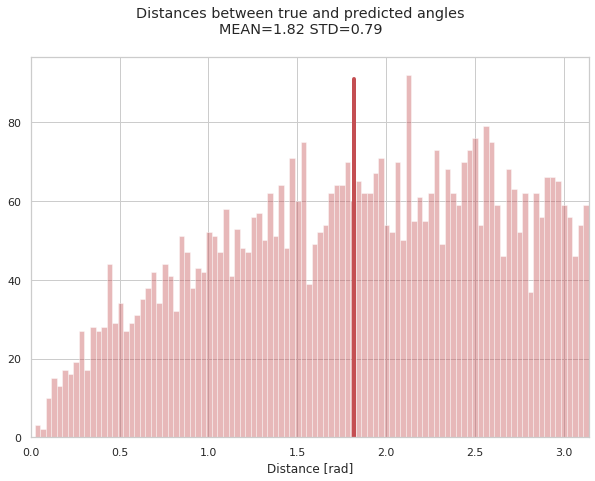

In [23]:
plot_distances_count(mat, angles_true)

In [24]:
distance_difference(angles_predicted=ap, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 1.820 rad (104.296 degrees)
Mean `rotation matrix` distance between true and predicted values: 1.820 rad (104.296 degrees)


In [12]:
mat = update_angles(m, rotation, ap)
mat

<tf.Tensor: id=2063275, shape=(5000, 3), dtype=float64, numpy=
array([[ 1.7028659 ,  0.8006694 ,  2.67080644],
       [-3.14119027,  0.52808697, -0.11209381],
       [-2.46516686,  0.19089514, -1.39001521],
       ...,
       [ 1.97281197,  1.08284854, -0.97822403],
       [-1.42389625,  0.66666269,  0.99643427],
       [-1.36442391,  0.81633011,  2.43787629]])>

In [13]:
angles_true

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

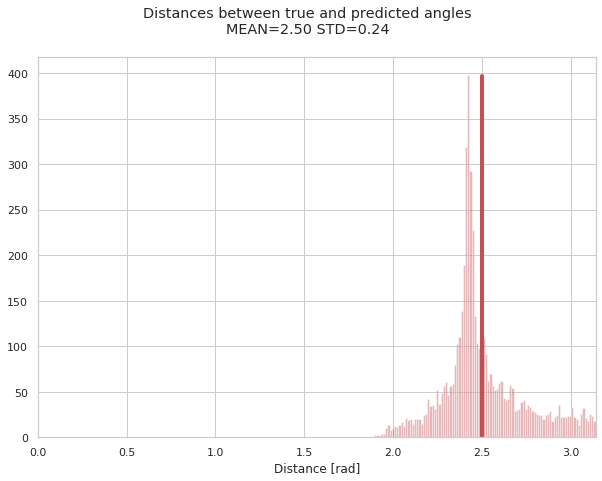

In [14]:
plot_distances_count(mat, angles_true)

In [15]:
distance_difference(angles_predicted=mat, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 2.503 rad (143.424 degrees)
Mean `rotation matrix` distance between true and predicted values: 2.503 rad (143.424 degrees)


In [13]:
plot_selected_angles_with_3rd_angle_magnitude(mat, angles_true, range(100))

In [42]:
display(ipv.screenshot())

Output()

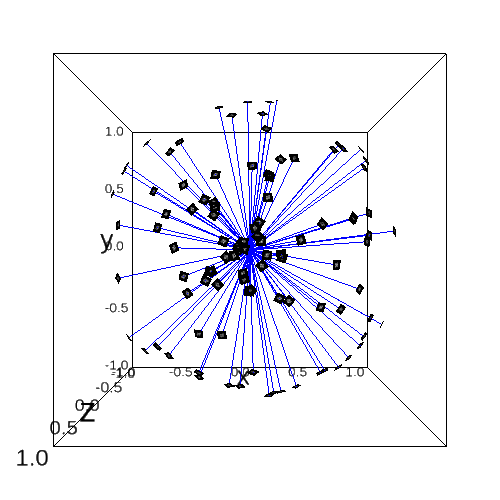

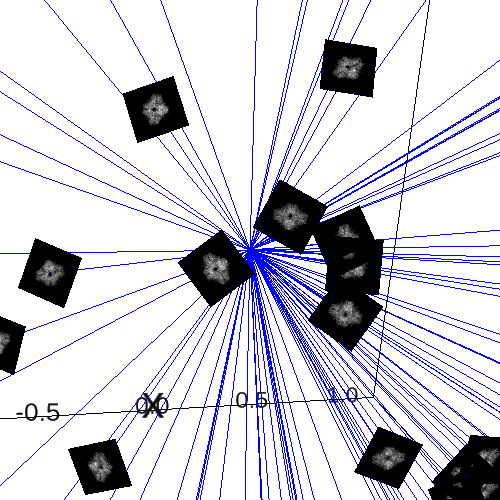

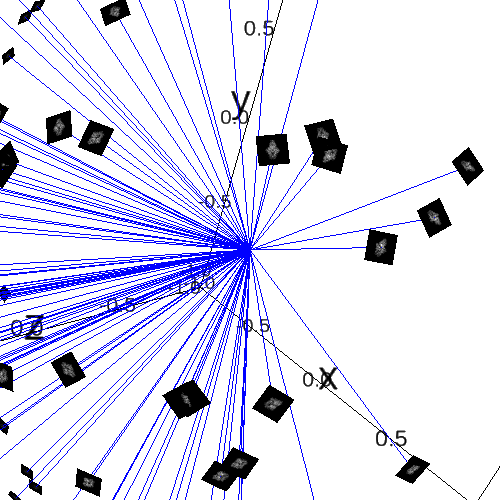

In [43]:
plot_images(mat, projections, indices=range(100),img_size_scale=0.05)

In [46]:
display(ipv.screenshot())

Output()

In [47]:
distance_difference(angles_predicted=mat, angles_true=angles_true);

Mean quaternion distance between true and predicted values:  1.809932162160245  rad ( 103.70147409676976  degrees)


1.809932162160245